# Exploratory Data  Analysis

In [98]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder, FunctionTransformer, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import plot_confusion_matrix, recall_score,\
    accuracy_score, precision_score, f1_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImPipeline

import ourfunctions

In [99]:
X = pd.read_csv('data/Training-set-values.csv')
y = pd.read_csv('data/Training-set-labels.csv')

In [121]:
drop_cols = ['subvillage',
 'region',
 'lga',
 'ward',
 'extraction_type_group',
 'extraction_type_class',
 'source_type',
 'waterpoint_type_group',
 'scheme_name',
 'payment',
 'quantity_group',
 'waterpoint_type_group',
 'recorded_by',
 'num_private',
 'date_recorded',
 'id']

In [101]:
df = pd.concat([X.drop(columns=drop_cols), y.drop(columns='id')], axis=1)

In [102]:
df.head()

,amount_tsh,funder,gps_height,installer,longitude,latitude,wpt_name,basin,region_code,district_code,...,management,management_group,payment_type,water_quality,quality_group,quantity,source,source_class,waterpoint_type,status_group
0,6000.0,Roman,1390,Roman,34.938093,-9.856322,none,Lake Nyasa,11,5,...,vwc,user-group,annually,soft,good,enough,spring,groundwater,communal standpipe,functional
1,0.0,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,Lake Victoria,20,2,...,wug,user-group,never pay,soft,good,insufficient,rainwater harvesting,surface,communal standpipe,functional
2,25.0,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,Pangani,21,4,...,vwc,user-group,per bucket,soft,good,enough,dam,surface,communal standpipe multiple,functional
3,0.0,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,Ruvuma / Southern Coast,90,63,...,vwc,user-group,never pay,soft,good,dry,machine dbh,groundwater,communal standpipe multiple,non functional
4,0.0,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,Lake Victoria,18,1,...,other,other,never pay,soft,good,seasonal,rainwater harvesting,surface,communal standpipe,functional


In [122]:
predictors = df.drop('status_group', axis = 1)
target = df['status_group']
target = LabelEncoder().fit_transform(target)


In [123]:
target_df = pd.DataFrame(target)

In [124]:
pd.Series(target).value_counts(1)

0    0.543081
2    0.384242
1    0.072677
dtype: float64

In [106]:
X_train, X_test, y_train, y_test = train_test_split(predictors, target, random_state=829941045)

### `Pipeline` and `FunctionTransformer`

In [107]:
def grab_numeric(predictors):
    return predictors.select_dtypes(include=['float', 'int'])

In [108]:
GrabNumeric = FunctionTransformer(grab_numeric)

In [109]:
pipe = Pipeline(steps=[('num', GrabNumeric),
                       ('ss', StandardScaler())])

In [110]:
pipe.fit(X_train)

Pipeline(steps=[('num',
                 FunctionTransformer(func=<function grab_numeric at 0x7fd07b950ee0>)),
                ('ss', StandardScaler())])

In [111]:
pipe.transform(X_train)

array([[-0.11043211, -0.96293588, -0.2513524 , ..., -0.06671378,
        -0.37708316, -1.36913891],
       [-0.11043211, -0.96293588, -0.20379217, ..., -0.06671378,
        -0.37708316, -1.36913891],
       [-0.00350461,  1.00208401,  0.54119042, ..., -0.37643645,
        -0.33524556,  0.74097128],
       ...,
       [-0.11043211,  0.89676356,  0.13581336, ..., -0.27319556,
        -0.25157035,  0.72625202],
       [-0.11043211,  1.36421322,  0.13265039, ..., -0.37643645,
        -0.37499128,  0.7441254 ],
       [-0.11043211,  0.98044282, -0.51103148, ..., -0.47967735,
         0.56426291,  0.7399199 ]])

### Using `Pipeline` and `ColumnTransformer`

In [112]:
subpipe_num = Pipeline(steps=[('num_impute', SimpleImputer()),
                           ('ss', StandardScaler())])
subpipe_cat = Pipeline(steps=[('cat_impute', SimpleImputer(strategy='most_frequent')),
                             ('ohe', OneHotEncoder(sparse=False, handle_unknown='ignore'))])

In [113]:
num_features = list(predictors.select_dtypes(include=['float', 'int']))
cat_features = list(predictors.select_dtypes(include=['object']))

In [114]:
CT = ColumnTransformer(transformers=[('subpipe_num', subpipe_num, num_features),
                                         ('subpipe_cat', subpipe_cat, cat_features)],
                           remainder='passthrough')

logreg_model_pipe = Pipeline(steps=[('ct', CT),
                            ('logreg', LogisticRegression(random_state=42))])

logreg_model_pipe.fit(X_train, y_train)

## KNearest Neighbors

In [127]:
model_run = ourfunctions.Modeler(X=predictors, y=target_df)

In [128]:
numeric_transformer = Pipeline(
    steps=[('imputer', SimpleImputer(strategy='median'))]
)

knn_preprocessor = ColumnTransformer(
    transformers=[
        ("numeric", numeric_transformer, make_column_selector(dtype_include=np.number)),
    ]
)

In [129]:
knn = {'classifier': KNeighborsClassifier(), 'preprocessor': knn_preprocessor}

model_run.add_model('KNN', knn)

In [130]:

cross_val_score(estimator=KNeighborsClassifier(),
                X=knn_preprocessor.fit_transform(X_train), 
                y=y_train)

array([0.64792368, 0.64938272, 0.65611672, 0.64938272, 0.64175084])

## Random Forest

In [140]:
class ModelWithCV():
    '''Structure to save the model and more easily see its crossvalidation'''
    
    def __init__(self, model, model_name, X, y, cv_now=True):
        self.model = model
        self.name = model_name
        self.X = X
        self.y = y
        # For CV results
        self.cv_results = None
        self.cv_mean = None
        self.cv_median = None
        self.cv_std = None
        #
        if cv_now:
            self.cross_validate()
        
    def cross_validate(self, X=None, y=None, kfolds=10):
        '''
        Perform cross-validation and return results.
        
        Args: 
          X:
            Optional; Training data to perform CV on. Otherwise use X from object
          y:
            Optional; Training data to perform CV on. Otherwise use y from object
          kfolds:
            Optional; Number of folds for CV (default is 10)  
        '''
        
        cv_X = X if X else self.X
        cv_y = y if y else self.y

        self.cv_results = cross_val_score(self.model, cv_X, cv_y, cv=kfolds)
        self.cv_mean = np.mean(self.cv_results)
        self.cv_median = np.median(self.cv_results)
        self.cv_std = np.std(self.cv_results)

        
    def print_cv_summary(self):
        cv_summary = (
        f'''CV Results for `{self.name}` model:
            {self.cv_mean:.5f} ± {self.cv_std:.5f} accuracy
        ''')
        print(cv_summary)

        
    def plot_cv(self, ax):
        '''
        Plot the cross-validation values using the array of results and given 
        Axis for plotting.
        '''
        ax.set_title(f'CV Results for `{self.name}` Model')
        # Thinner violinplot with higher bw
        sns.violinplot(y=self.cv_results, ax=ax, bw=.4)
        sns.swarmplot(
                y=self.cv_results,
                color='orange',
                size=10,
                alpha= 0.8,
                ax=ax
        )

        return ax
        

In [131]:
numeric_transformer = Pipeline(
            steps=[('imputer', SimpleImputer(strategy='median'))]
        )

categorical_transformer = Pipeline(
    steps=[('imputer', SimpleImputer(strategy='constant', fill_value='Missing'))]
        )

random_forest_preprocessor = ColumnTransformer(
    transformers=[
        ("numeric", numeric_transformer, make_column_selector(dtype_include=np.number)),
        ("categorical", categorical_transformer, make_column_selector(dtype_exclude=np.number))]
        )

In [132]:
rndm_f = {'classifier': RandomForestClassifier(), 'preprocessor': random_forest_preprocessor}

model_run.add_model('RF', rndm_f)

In [134]:
numeric_transformer = Pipeline(
            steps=[('imputer', SimpleImputer(strategy='median'))]
        )

categorical_transformer = Pipeline(
    steps=[('imputer', SimpleImputer(strategy='constant', fill_value='Missing')),
            ('one_hot_encode', OneHotEncoder(handle_unknown='ignore'))]
        )

random_forest_preprocessor = ColumnTransformer(
    transformers=[
        ("numeric", numeric_transformer, make_column_selector(dtype_include=np.number)),
        ("categorical", categorical_transformer, make_column_selector(dtype_exclude=np.number))]
        )

In [135]:
rfc = RandomForestClassifier(random_state=42)

rfc_model_pipe = Pipeline([('ct', CT), ('rfc', rfc)])

In [136]:
rfc_model_pipe.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('subpipe_num',
                                                  Pipeline(steps=[('num_impute',
                                                                   SimpleImputer()),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  ['amount_tsh', 'gps_height',
                                                   'longitude', 'latitude',
                                                   'region_code',
                                                   'district_code',
                                                   'population',
                                                   'construction_year']),
                                                 ('subpipe_cat',
                                

In [138]:
rfc_model_pipe.score(X_train, y_train)

0.9997530864197531

In [141]:
forest_pipe = ModelWithCV(model=rfc_model_pipe,
                          model_name='forest_pipe',
                          X=X_train,
                          y=y_train)
                          

matplotlib.font_manager - DEBUG - findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=12.0.
matplotlib.font_manager - DEBUG - findfont: score(<Font 'DejaVu Serif Display' (DejaVuSerifDisplay.ttf) normal normal 400 normal>) = 10.05
matplotlib.font_manager - DEBUG - findfont: score(<Font 'DejaVu Sans' (DejaVuSans-Oblique.ttf) oblique normal 400 normal>) = 1.05
matplotlib.font_manager - DEBUG - findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono-Bold.ttf) normal normal 700 normal>) = 10.335
matplotlib.font_manager - DEBUG - findfont: score(<Font 'cmmi10' (cmmi10.ttf) normal normal 400 normal>) = 10.05
matplotlib.font_manager - DEBUG - findfont: score(<Font 'DejaVu Sans' (DejaVuSans-BoldOblique.ttf) oblique normal 700 normal>) = 1.335
matplotlib.font_manager - DEBUG - findfont: score(<Font 'DejaVu Serif' (DejaVuSerif.ttf) normal normal 400 normal>) = 10.05
matplotlib.font_manager - DEBUG - findfont: score(<Font 'STIXNonUnicode' (STIXNonUniIta.t

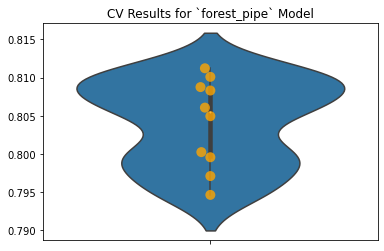

In [142]:
fig, ax = plt.subplots()

forest_pipe.plot_cv(ax=ax);